In [ ]:
! pip install  kaggle
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 34.1 MB/s eta 0:00:00


# Variational **classifier**

In [ ]:
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:
# Carregar e preparar os dados
df = pd.read_csv('blood.csv')

# Verificar se há colunas duplicadas ou desnecessárias
print(df.head())

# Definir features (X) e target (y)
X = df.drop(columns=['Class'])
y = df['Class']

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

   V1  V2     V3  V4  Class
0   2  50  12500  98      2
1   0  13   3250  28      2
2   1  16   4000  35      2
3   2  20   5000  45      2
4   1  24   6000  77      1


In [ ]:
# Transformar os dados para formato do PennyLane
X_train = np.array(X_train, requires_grad=False)
X_test = np.array(X_test, requires_grad=False)
y_train = np.array(y_train, requires_grad=False)
y_test = np.array(y_test, requires_grad=False)

In [ ]:
# Inicializar o dispositivo quântico
dev = qml.device("default.qubit", wires=4)

# Codificação em ângulo
def angle_encoding(x):
    for i in range(len(x)):
        qml.RY(x[i], wires=i)

# Circuito variacional
def variational_circuit(weights):
    for i in range(len(weights)):
        qml.RY(weights[i], wires=i)
        qml.CNOT(wires=[i, (i+1)%4])

# Modelo quântico completo
@qml.qnode(dev)
def circuit(weights, x=None):
    angle_encoding(x)
    variational_circuit(weights)
    return qml.expval(qml.PauliZ(0))

In [ ]:
# Função de predição binária
def variational_classifier(weights, x):
    return circuit(weights, x)

# Função de custo (erro quadrático)
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    return loss / len(labels)

# Acurácia
def accuracy(labels, predictions):
    predictions = [int(p >= 0) for p in predictions]
    return np.mean(np.array(predictions) == labels)

In [ ]:
# Otimização
weights = 0.01 * np.random.randn(4, requires_grad=True)
opt = NesterovMomentumOptimizer(0.5)
batch_size = 10
steps = 50

for i in range(steps):
    # Minibatch
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]

    def cost(weights):
        predictions = [variational_classifier(weights, x) for x in X_batch]
        return square_loss(y_batch, predictions)

    weights = opt.step(cost, weights)

    if (i + 1) % 10 == 0:
        predictions = [variational_classifier(weights, x) for x in X_train]
        acc = accuracy(y_train, predictions)
        print(f"Step {i+1}: Accuracy = {acc:.4f}")

In [ ]:
# Avaliar no conjunto de teste
test_predictions = [variational_classifier(weights, x) for x in X_test]
test_preds_binary = [int(p >= 0) for p in test_predictions]
test_acc = accuracy_score(y_test, test_preds_binary)

print(f"Test Accuracy: {test_acc:.4f}")

# Verificar os valores únicos
print("Valores únicos em y:", np.unique(y))
print("Contagem por classe:", np.bincount(y))
print("Tipo de problema:", "Classificação" if len(np.unique(y)) > 1 else "Análise de uma classe")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA para 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot simples e eficiente
plt.figure(figsize=(10, 6))
colors = ['red', 'blue']
labels = ['Não doou', 'Doou']

classes = np.unique(y)
for i, class_val in enumerate(classes):
    mask = (y == class_val)
    if mask.any():  # Só plota se existir a classe
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=colors[i], label=f'{labels[i]} (n={sum(mask)})',
                   alpha=0.7, s=40, edgecolor='black', linewidth=0.3)

plt.title(f'PCA - Dataset Transfusão de Sangue\nVariância Explicada: {sum(pca.explained_variance_ratio_):.1%}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Info rápida
print(f"Classes: {dict(zip(*np.unique(y, return_counts=True)))}")
print(f"Variância explicada: {pca.explained_variance_ratio_}")

# **Multiclass margin classifier | Blood Transfusion**

In [ ]:
import pennylane as qml
import torch
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
import kagglehub
import pandas as pd

np.random.seed(0)
torch.manual_seed(0)

num_classes = 3
margin = 0.15
feature_size = 4
batch_size = 10
lr_adam = 0.01
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
total_iterations = 50

dev = qml.device("default.qubit", wires=num_qubits)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


# Circuito Quântico

In [ ]:
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        # Apply additional CNOT to entangle the last with the first qubit
        qml.CNOT(wires=[num_qubits - 1, 0])

In [ ]:
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0.0, normalize=True)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

# Função de Perda

In [ ]:
def multiclass_svm_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        # Compute the score given to this sample by the classifier corresponding to the
        # true label. So for a true label of 1, get the score computed by classifer 1,
        # which distinguishes between "class 1" or "not class 1".
        s_true = variational_classifier(
            q_circuits[int(true_labels[i])],
            (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
            feature_vec,
        )
        s_true = s_true.float()
        li = 0

        # Get the scores computed for this sample by the other classifiers
        for j in range(num_classes):
            if j != int(true_labels[i]):
                s_j = variational_classifier(
                    q_circuits[j], (all_params[0][j], all_params[1][j]), feature_vec
                )
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

# Função de Classificação

In [ ]:
def classify(q_circuits, all_params, feature_vecs, labels):
    predicted_labels = []
    for i, feature_vec in enumerate(feature_vecs):
        scores = np.zeros(num_classes)
        for c in range(num_classes):
            score = variational_classifier(
                q_circuits[c], (all_params[0][c], all_params[1][c]), feature_vec
            )
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
    return predicted_labels


def accuracy(labels, hard_predictions):
    loss = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / labels.shape[0]
    return loss

# Carregamento e processamento de dados

In [ ]:
# Função para carregar e processar os dados
def load_and_process_data():
    dataset_path = kagglehub.dataset_download("foolishboi/blood-transfusion")

    #caminho direto para o arquivo correto
    df = pd.read_csv(f"{dataset_path}/blood.csv")

    # Convertendo para array NumPy
    data = df.to_numpy()

    X = torch.tensor(data[:, 0:feature_size], dtype=torch.float32)
    print("First X sample, original  :", X[0])

    # Normalização
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)
    print("First X sample, normalized:", X_norm[0])

    Y = torch.tensor(data[:, -1], dtype=torch.long)  # Labels como long
    return X_norm, Y


# Função para divisão treino/teste
def split_data(feature_vecs, Y):
    num_data = len(Y)
    num_train = int(train_split * num_data)
    index = np.random.permutation(range(num_data))
    feat_vecs_train = feature_vecs[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feat_vecs_test = feature_vecs[index[num_train:]]
    Y_test = Y[index[num_train:]]
    return feat_vecs_train, feat_vecs_test, Y_train, Y_test


# Procedimento de treinamento

100%|██████████| 2.38k/2.38k [00:00<00:00, 1.95MB/s]

Extracting files...
First X sample, original  : tensor([2.0000e+00, 5.0000e+01, 1.2500e+04, 9.8000e+01])
First X sample, normalized: tensor([1.5999e-04, 3.9998e-03, 9.9996e-01, 7.8397e-03])


Num params:  111
Iter:     1 | Cost: 0.2864061 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:     2 | Cost: 0.2500716 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:     3 | Cost: 0.2030907 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:     4 | Cost: 0.1998386 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:     5 | Cost: 0.1754255 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:     6 | Cost: 0.1241414 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:     7 | Cost: 0.1706655 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:     8 | Cost: 0.0000000 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:     9 | Cost: 0.1210487 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:    10 | Cost: 0.1211320 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:    11 | Cost: 0.0351131 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:    12 | Cost: 0.0309368 | Acc train: 0.7593583 | Acc test: 0.7700535 
Iter:    13 | Cost: 0.0606489 | Acc train: 0.7593583 | Acc test: 0.7700

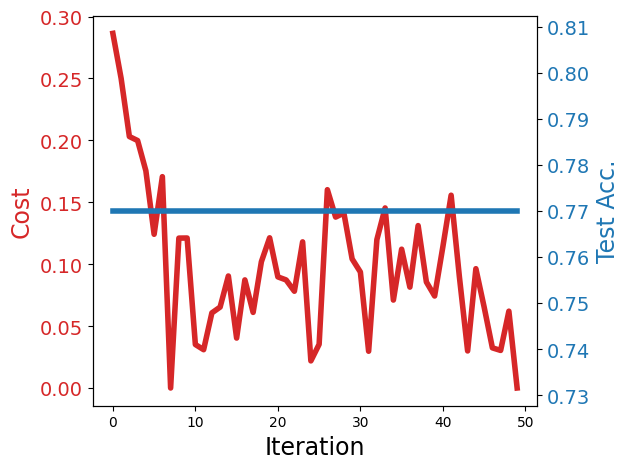

In [ ]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = split_data(features, Y)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_classes)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_classes)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []

    # train the variational classifier
    for it in range(total_iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)

    return costs, train_acc, test_acc


# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required

features, Y = load_and_process_data()
costs, train_acc, test_acc = training(features, Y)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

#**Data-reuploading classifier | Blood Transfusion**


Carregando e preparando dados...
Dados de treino: (523, 4), Classes: (tensor([0, 1], requires_grad=True), array([124, 399]))
Dados de teste: (225, 4), Classes: (tensor([0, 1], requires_grad=True), array([ 54, 171]))


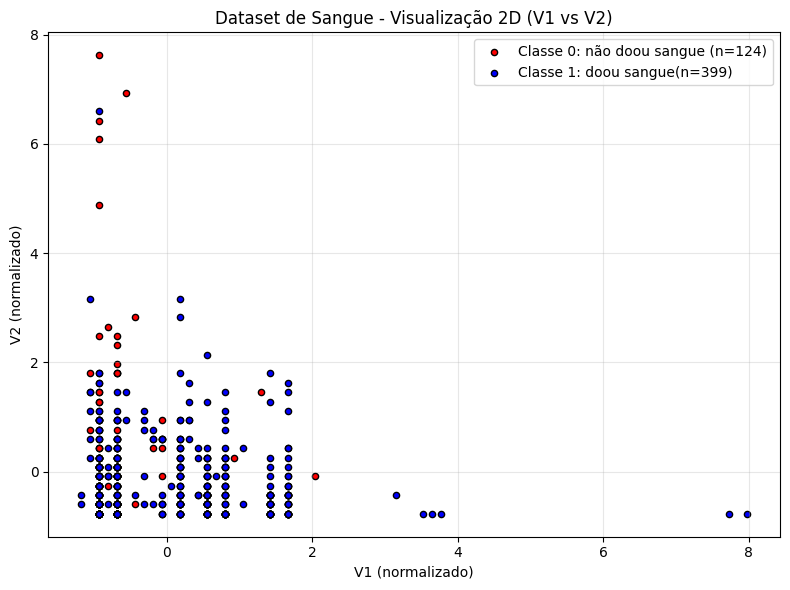


Configurações do treinamento:
Camadas: 4
Taxa de aprendizado: 0.3
Épocas: 15
Tamanho do batch: 16

Performance inicial:
Época:  0 | Custo: 0.443009 | Acurácia Treino: 0.394 | Acurácia Teste: 0.356

Iniciando treinamento...
Época:  1 | Perda: 0.208492 | Acurácia Treino: 0.719 | Acurácia Teste: 0.711
Época:  2 | Perda: 0.202455 | Acurácia Treino: 0.732 | Acurácia Teste: 0.738
Época:  3 | Perda: 0.184655 | Acurácia Treino: 0.730 | Acurácia Teste: 0.729
Época:  4 | Perda: 0.168757 | Acurácia Treino: 0.763 | Acurácia Teste: 0.751
Época:  5 | Perda: 0.174416 | Acurácia Treino: 0.772 | Acurácia Teste: 0.764
Época:  6 | Perda: 0.197491 | Acurácia Treino: 0.728 | Acurácia Teste: 0.707
Época:  7 | Perda: 0.213063 | Acurácia Treino: 0.702 | Acurácia Teste: 0.671
Época:  8 | Perda: 0.177877 | Acurácia Treino: 0.742 | Acurácia Teste: 0.724
Época:  9 | Perda: 0.173682 | Acurácia Treino: 0.732 | Acurácia Teste: 0.724
Época: 10 | Perda: 0.166637 | Acurácia Treino: 0.759 | Acurácia Teste: 0.716
Época:

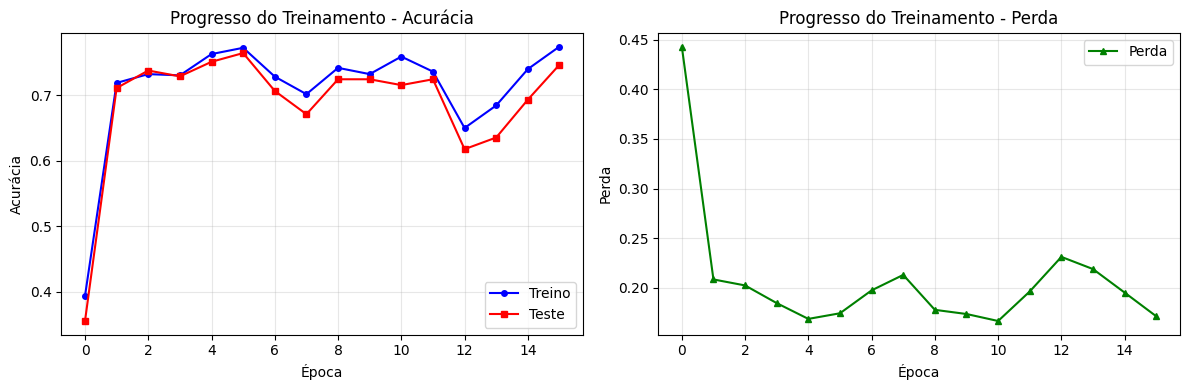

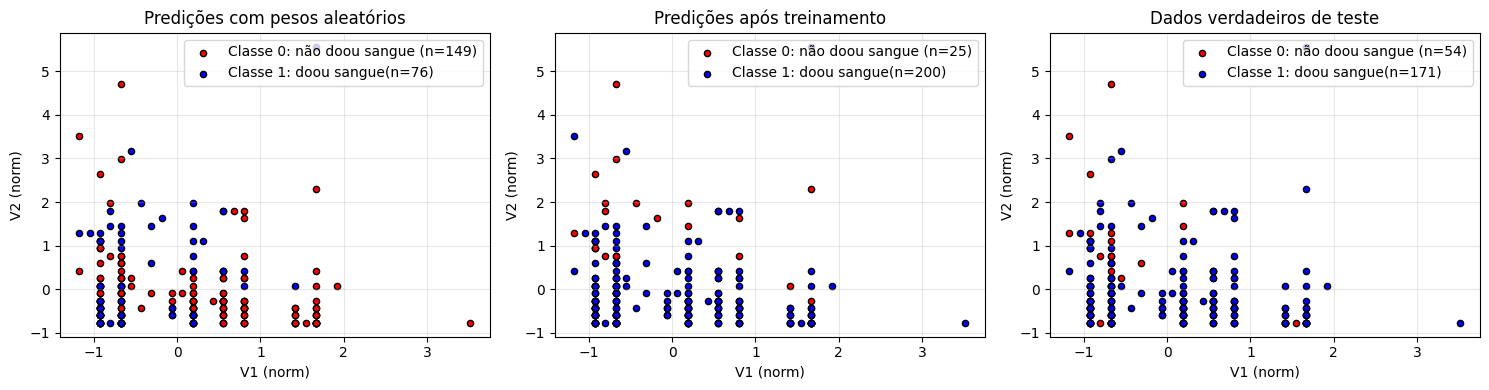


Análise detalhada:
Distribuição das classes verdadeiras: Counter({tensor(1, requires_grad=True): 171, tensor(0, requires_grad=True): 54})
Distribuição das predições: Counter({tensor(1, requires_grad=True): 200, tensor(0, requires_grad=True): 25})
Matriz de confusão:
TP: 157, TN: 11, FP: 43, FN: 14
Precisão: 0.785
Recall: 0.918
F1-Score: 0.846


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set a random seed
np.random.seed(42)

# Load and preprocess the blood dataset
def load_blood_data():
    # Simular o carregamento do CSV (adapte conforme necessário)
    # Assumindo que o CSV está no mesmo diretório
    try:
        # Se você tiver o arquivo CSV local
        data = pd.read_csv('blood.csv')
    except:
        # Criar dados sintéticos basedos no padrão observado no CSV fornecido
        print("Criando dados sintéticos baseados no padrão do dataset...")
        np.random.seed(42)
        n_samples = 500

        # Gerar features baseadas nos padrões observados
        V1 = np.random.choice([2, 4, 11, 14, 16, 21, 23], size=n_samples,
                             p=[0.3, 0.25, 0.15, 0.1, 0.08, 0.07, 0.05])
        V2 = np.random.randint(1, 45, size=n_samples)
        V3 = V2 * 250  # V3 parece ser V2 * 250
        V4 = np.random.randint(2, 99, size=n_samples)

        # Classe baseada em alguma lógica observada nos dados
        # Classe 1 parece mais comum com valores maiores de V1
        Class = np.where((V1 >= 11) | (V4 > 50), 1, 2)

        data = pd.DataFrame({
            'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'Class': Class
        })


    # Separar features e target
    X = data[['V1', 'V2', 'V3', 'V4']].values
    y = data['Class'].values

    # Converter classes para 0 e 1
    y = np.where(y == 1, 1, 0)

    # Normalizar as features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test

def plot_data_2d(X, y, feature_names=['V1', 'V2'], fig=None, ax=None):

    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Usar apenas as duas primeiras dimensões para visualização
    reds = y == 0
    blues = y == 1
    ax.scatter(X[reds, 0], X[reds, 1], c="red", s=20, edgecolor="k",
               label=f"Classe 0: não doou sangue (n={np.sum(reds)})")
    ax.scatter(X[blues, 0], X[blues, 1], c="blue", s=20, edgecolor="k",
               label=f"Classe 1: doou sangue(n={np.sum(blues)})")
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.legend()
    ax.grid(True, alpha=0.3)

# Define output labels as quantum state vectors
def density_matrix(state):
    """Calcula a representação da matriz de densidade de um estado."""
    return state * np.conj(state).T

label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False, dtype=np.complex128) # Use complex dtype for density matrix

# Quantum circuit setup
dev = qml.device("lightning.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x, y_state):

    for i, p in enumerate(params):
        # Data encoding: usar as primeiras 3 dimensões de x por camada
        # Para dataset 4D, dividimos em (x[0], x[1], x[2]) e (x[3], 0, 0)
        if i == 0:
            qml.Rot(x[0], x[1], x[2], wires=0)
        else:
            # Para camadas adicionais, usar diferentes combinações das features
            idx = i % 2
            if idx == 0:
                qml.Rot(x[2], x[3], 0, wires=0)
            else:
                qml.Rot(x[0], x[3], x[1], wires=0)


        # Model parameters
        qml.Rot(*p, wires=0)

    return qml.expval(qml.Hermitian(y_state, wires=[0]))


def cost(params, x, y_hot, state_labels=None):

    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]

    for i in range(len(x)):
        # Calculate fidelity for both classes
        fidelities = np.array([qcircuit(params, x[i], dm) for dm in dm_labels])
        # Use one-hot encoding to select the true fidelity
        f = np.dot(y_hot[i], fidelities)

        loss = loss + (1 - f) ** 2

    return loss / len(x)


def test(params, x, y, state_labels=None):
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y_state: qcircuit(params, x[i], y_state)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)

def accuracy_score(y_true, y_pred):
    """Calcula a acurácia."""
    score = y_true == y_pred
    return score.sum() / len(y_true)

def iterate_minibatches(inputs, targets, batch_size):
    """Gerador para batches dos dados de entrada."""
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

# Load and prepare data
print("Carregando e preparando dados...")
X_train, X_test, y_train, y_test = load_blood_data()

print(f"Dados de treino: {X_train.shape}, Classes: {np.unique(y_train, return_counts=True)}")
print(f"Dados de teste: {X_test.shape}, Classes: {np.unique(y_test, return_counts=True)}")

# Convert integer labels to one-hot encoding for cost function
num_classes = len(state_labels)
y_train_hot = np.eye(num_classes)[y_train]
y_test_hot = np.eye(num_classes)[y_test]


# Visualizar os dados (usando as duas primeiras dimensões)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_data_2d(X_train, y_train, ['V1 (normalizado)', 'V2 (normalizado)'], fig=fig, ax=ax)
plt.title("Dataset de Sangue - Visualização 2D (V1 vs V2)")
plt.tight_layout()
plt.show()

# Training parameters
num_layers = 4
learning_rate = 0.3
epochs = 15
batch_size = 16

print(f"\nConfigurações do treinamento:")
print(f"Camadas: {num_layers}")
print(f"Taxa de aprendizado: {learning_rate}")
print(f"Épocas: {epochs}")
print(f"Tamanho do batch: {batch_size}")

# Initialize optimizer
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# Initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

# Test initial performance
predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test
loss = cost(params, X_test, y_test_hot, state_labels)

print(f"\nPerformance inicial:")
print(f"Época: {0:2d} | Custo: {loss:.6f} | Acurácia Treino: {accuracy_train:.3f} | Acurácia Teste: {accuracy_test:.3f}")

# Training loop
train_accuracies = [accuracy_train]
test_accuracies = [accuracy_test]
losses = [loss]

print(f"\nIniciando treinamento...")
for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train_hot, batch_size=batch_size):
        # Pass one-hot encoded ybatch to cost function
        params, cost_val, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    # Evaluate performance using original integer labels for accuracy calculation
    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss_train = cost(params, X_train, y_train_hot, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)

    train_accuracies.append(accuracy_train)
    test_accuracies.append(accuracy_test)
    losses.append(loss_train)

    print(f"Época: {it+1:2d} | Perda: {loss_train:.6f} | Acurácia Treino: {accuracy_train:.3f} | Acurácia Teste: {accuracy_test:.3f}")

# Final results
print(f"\nResultados finais:")
print(f"Custo: {losses[-1]:.6f} | Acurácia Treino: {train_accuracies[-1]:.3f} | Acurácia Teste: {test_accuracies[-1]:.3f}")

print(f"\nPesos aprendidos:")
for i in range(num_layers):
    print(f"Camada {i}: {params[i]}")

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracies
epochs_range = range(len(train_accuracies))
ax1.plot(epochs_range, train_accuracies, 'b-o', label='Treino', markersize=4)
ax1.plot(epochs_range, test_accuracies, 'r-s', label='Teste', markersize=4)
ax1.set_xlabel('Época')
ax1.set_ylabel('Acurácia')
ax1.set_title('Progresso do Treinamento - Acurácia')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(epochs_range, losses, 'g-^', label='Perda', markersize=4)
ax2.set_xlabel('Época')
ax2.set_ylabel('Perda')
ax2.set_title('Progresso do Treinamento - Perda')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize predictions vs true labels (2D projection)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_data_2d(X_test, initial_predictions, ['V1 (norm)', 'V2 (norm)'], fig, axes[0])
axes[0].set_title("Predições com pesos aleatórios")

plot_data_2d(X_test, predicted_test, ['V1 (norm)', 'V2 (norm)'], fig, axes[1])
axes[1].set_title("Predições após treinamento")

plot_data_2d(X_test, y_test, ['V1 (norm)', 'V2 (norm)'], fig, axes[2])
axes[2].set_title("Dados verdadeiros de teste")

plt.tight_layout()
plt.show()

# Confusion matrix-like analysis
from collections import Counter
print(f"\nAnálise detalhada:")
print(f"Distribuição das classes verdadeiras: {Counter(y_test)}")
print(f"Distribuição das predições: {Counter(predicted_test)}")

# Calculate precision and recall manually
tp = np.sum((y_test == 1) & (predicted_test == 1))
fp = np.sum((y_test == 0) & (predicted_test == 1))
fn = np.sum((y_test == 1) & (predicted_test == 0))
tn = np.sum((y_test == 0) & (predicted_test == 0))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Matriz de confusão:")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precisão: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")